## Init Modules

In [ ]:
%load_ext autoreload
%autoreload 2

from PIL import Image, ImageDraw, ImageFont
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import numpy as np
import os

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

def image_crop(img, row, col, H=1024, W=1024):
    return img.crop((H * col, W * row, H * (col + 1), W * (row + 1)))

def column_named(grid, names, font=ImageFont.truetype("/home/mdnikolaev/ImageEditing/tmp_img/times.ttf", 120), H=1024, W=1024, alpha=1):
    draw = ImageDraw.Draw(grid)
    W_, H_ = grid.size
    ws, hw = zip(*[draw.textbbox((0, 0), name, font=font)[-2:] for name in names])
    new_img = Image.new('RGB', (W_, H_ + max(hw) + 100), (255, 255, 255))
    if alpha != 1:
        alpha = Image.new("L", new_img.size, int(255 * alpha))
        new_img.putalpha(alpha)
    
    draw = ImageDraw.Draw(new_img)
    W_, H_ = new_img.size
    new_img.paste(grid, box=(0, max(hw) + 100))
    for i, name in enumerate(names):
        draw.text((W * i + (W-ws[i])/2, max(hw) - min(hw) + 50), name, font=font, fill='black')
    return new_img

def column_named2(grid, names, font=ImageFont.truetype("/home/mdnikolaev/ImageEditing/tmp_img/times.ttf", 120), H=1024, W=1024):
    draw = ImageDraw.Draw(grid)
    W_, H_ = grid.size
    ws, hw = zip(*[draw.textbbox((0, 0), name, font=font)[-2:] for name in names])
    new_img = Image.new('RGB', (W_, H_ + max(hw) + 100), (255, 255, 255))
    
    draw = ImageDraw.Draw(new_img)
    W_, H_ = new_img.size
    new_img.paste(grid, box=(0, max(hw) + 100))
    for i, name in enumerate(names):
        draw.text((W * i + (W-ws[i])/2, max(hw) - hw[i] + 50), name, font=font, fill='black')
    return new_img

def split_horiz(img, col, shift=10):
    W, H = img.size
    new_img = Image.new('RGB', (W + shift, H), (255, 255, 255))
    new_img.paste(img.crop((0, 0, col * 1024, H)), box=(0, 0))
    new_img.paste(img.crop((col * 1024, 0, W, H)), box=(col * 1024 + shift, 0))
    return new_img


/home/sasedov/.conda/envs/StyleDomain-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


OSError: cannot open resource

In [ ]:
def get_transform_image_exp(exps, exp_to_path, col_names=None, named=True, head=3, shift=10):
    exp_to_imgs = {}
    rows_name = None
    for exp in exps:
        data = exp_to_path[exp]
        exp_to_imgs[exp] = [Image.open(path).resize((1024, 1024), resample=Image.LANCZOS) for path in data.values()]
        rows_name = rows_name or list(data.keys())
        assert rows_name == list(data.keys())
        
    
    imgs_to_grid = [exp_to_imgs[exp][i] for exp in exps for i in range(len(rows_name))]
    grid = image_grid(imgs_to_grid, len(exps), len(rows_name))
    _, height = grid.size
    
    grid_table_rot = column_named(grid, rows_name)
    grid_name_splt = split_horiz(grid_table_rot, head, shift)
    if named:
        if col_names is not None:
            grid_name_rot = column_named(grid_name_splt.rotate(-90, expand=True), col_names[::-1], W=height // len(col_names)).rotate(90, expand=True)
        else:
            grid_name_rot = column_named(grid_name_splt.rotate(-90, expand=True), [exp[:10] for exp in exps[::-1]]).rotate(90, expand=True)
    else:
        grid_name_rot = grid_name_splt
    return grid_name_rot

In [ ]:
datasets_dir = {
    'CelebA':  ['/home/mdnikolaev/ImageEditing/CelebA-HQ-img'],
    
    'CtrlHair':       ["/home/aalanov/Nikolaev_Maxim/Datasets/CtrlHair/transfer3_celeba"],
    'CtrlHair wo PP': ["/home/aalanov/Nikolaev_Maxim/Datasets/CtrlHair/transfer3_celeba_wopp"],
    
    'Ours new-dataset': ["/home/aalanov/Nikolaev_Maxim/Datasets/Ours/transfer3_celeba_new-dataset"],
    'Ours clip':        ["/home/aalanov/Nikolaev_Maxim/Datasets/Ours/transfer3_celeba_clip"],
    'Ours back-loss':   ["/home/aalanov/Nikolaev_Maxim/Datasets/Ours/transfer3_celeba_back-loss"],
    
    'Ours new-dataset wo PP': ["/home/aalanov/Nikolaev_Maxim/Datasets/Ours/transfer3_celeba_new-dataset/Blend_realistic"],
    'Ours clip wo PP':        ["/home/aalanov/Nikolaev_Maxim/Datasets/Ours/transfer3_celeba_clip/Blend_realistic"],
    'Ours back-loss wo PP':   ["/home/aalanov/Nikolaev_Maxim/Datasets/Ours/transfer3_celeba_back-loss/Blend_realistic"],
    
    'StyleYourHair': [
        "/home/aalanov/Nikolaev_Maxim/Datasets/StyleYourHair/transfer3_celeba_1",
        "/home/aalanov/Nikolaev_Maxim/Datasets/StyleYourHair/transfer3_celeba_2",
        "/home/aalanov/Nikolaev_Maxim/Datasets/StyleYourHair/transfer3_celeba_3",
    ],
    
    'Barbershop': [
        "/home/aalanov/Nikolaev_Maxim/Datasets/Barbershop/transfer3_celeba_1",
        "/home/aalanov/Nikolaev_Maxim/Datasets/Barbershop/transfer3_celeba_2",
        "/home/aalanov/Nikolaev_Maxim/Datasets/Barbershop/transfer3_celeba_3"
    ],
    
    'HairCLIP': [
        "/home/aalanov/Nikolaev_Maxim/Datasets/HairCLIP/transfer3_celeba_1",
        "/home/aalanov/Nikolaev_Maxim/Datasets/HairCLIP/transfer3_celeba_2",
        "/home/aalanov/Nikolaev_Maxim/Datasets/HairCLIP/transfer3_celeba_3",
    ],
}

## Methods Compare

In [ ]:
exps = []
for path in datasets_dir['Barbershop']:
    imgs = []
    for img in os.listdir(path):
        if '.png' in img and 'vis_mask' not in img:
            imgs.append(img)
    exps.extend(['_'.join(img.split('_')[:3]) for img in imgs])
exps = exps[:1_000]

In [ ]:
from collections import OrderedDict

exp_to_path = {}
for exp in exps:
    face, shape, color = exp.split('_')
    exp_to_path[exp] = OrderedDict([
        ('Face', f'{datasets_dir["CelebA"][0]}/{face}.jpg'),
        ('Shape', f'{datasets_dir["CelebA"][0]}/{shape}.jpg'),
        ('Color', f'{datasets_dir["CelebA"][0]}/{color}.jpg'),
        ('Ours',                     f'{datasets_dir["Ours clip"][0]}/{exp}_realistic_blender_rotate.png'),
        ('Barbershop', f'{datasets_dir["Barbershop"][0]}/{exp}_realistic.png'),
        # ('Ours + PP',                f'{datasets_dir["Ours"][0]}/{exp}_realistic_blender_PP.png'),
        # ('Ours clip',                f'{datasets_dir["Ours CLIP"][0]}/{exp}_realistic_blender.png'),
        # ('Ours clip + cuda PP',      f'{datasets_dir["Ours CLIP"][0]}/{exp}_realistic_blender_PP.png'),
        # ('Rotate CLIP',           f'{datasets_dir["Rotate CLIP"][0]}/{exp}_realistic_blender_rotate.png'),
        # ('Ours + PP', f'{datasets_dir["Rotate CLIP"][0]}/{exp}_realistic_blender_rotate_PP.png'),
        # ('PP model', f'{datasets_dir["PPmodel"][0]}/{exp}_realistic_blender_rotate_PP.png'),
        ('CtrlHair', f'{datasets_dir["CtrlHair"][0]}/{exp}.png'),
        ('HairCLIP', f'{datasets_dir["CtrlHair"][0]}/{exp}.png'),
        # ('back-loss-reg', f'{datasets_dir["back-loss-reg"][0]}/{exp}_realistic_blender_rotate.png'),
        # ('back-loss', f'{datasets_dir["back-loss"][0]}/{exp}_realistic_blender_rotate.png'),
        # ('new-dataset', f'{datasets_dir["new-dataset"][0]}/{exp}_realistic_blender_rotate.png'),
        # ('baseline', f'{datasets_dir["baseline"][0]}/{exp}_realistic_blender_rotate.png'),
        # ('clip_def', f'{datasets_dir["clip_def"][0]}/{exp}_realistic_blender_rotate.png'),
        # ('lpips', f'{datasets_dir["lpips"][0]}/{exp}_realistic_blender_rotate.png'),
    ])
    prefix = '_'.join(exp.split('_')[:2])
    if os.path.isfile(f'{datasets_dir["StyleYourHair"][0]}/{prefix}.png'):
        exp_to_path[exp]['StyleYourHair'] = f'{datasets_dir["StyleYourHair"][0]}/{prefix}.png'
    else:
        exp_to_path[exp]['StyleYourHair'] = f'{datasets_dir["StyleYourHair"][0]}/{prefix}_flip.png'

### Random compare

In [ ]:
path_to_save = '/home/aalanov/Nikolaev_Maxim/exps/pp-compare-1210/'
os.makedirs(path_to_save, exist_ok=True)

In [1]:
N = 8

np.random.seed(1729)
images = np.random.choice(len(exp_to_path), size=50*N, replace=False)
for n_batch in tqdm(range(len(images) // N)):
    try:
        batch = images[N * n_batch: N * (n_batch + 1)]
        batch_exp = [exps[i] for i in batch]
        img = get_transform_image_exp(batch_exp, exp_to_path)
        img.save(os.path.join(path_to_save, f'test-image-{n_batch}.webp'), quality=100)
    except:
        pass

NameError: name 'exp_to_path' is not defined

### Blending compare

In [4]:
exp_to_path = {}
for exp in exps:
    face, shape, color = exp.split('_')
    exp_to_path[exp] = {
        'Ours': f'{datasets_dir["Ours"][0]}/{exp}_realistic_blender.png',
        'Face': f'{datasets_dir["CelebA"][0]}/{face}.jpg',
        'Shape': f'{datasets_dir["CelebA"][0]}/{shape}.jpg',
        'Color': f'{datasets_dir["CelebA"][0]}/{color}.jpg',
    }
    for name in ['Blend. Modul.', 'Blend. Clip.', 'Blend. Clip.MSE256', 'Blend. Clip.Style.MSE32', 'Ours']:
        if name == 'Blend. Modul.':
            exp_to_path[exp][name] = f'{datasets_dir[name][0]}/{exp}_realistic_modulation.png'
        else:
            exp_to_path[exp][name] = f'{datasets_dir[name][0]}/{exp}_realistic_blender.png'

In [7]:
N = 8

images = list(range(5 * N))
for n_batch in tqdm(range(len(images) // N)):
    batch = images[N * n_batch: N * (n_batch + 1)]
    batch_exp = [exps[i] for i in batch]
    img = get_transform_image_exp(batch_exp, rows=['Face', 'Shape', 'Color', 'Ours',
                                        'Blend. Modul.', 'Blend. Clip.', 'Blend. Clip.MSE256', 'Blend. Clip.Style.MSE32'])
    img.save(f'/home/mdnikolaev/ImageEditing/exps/methods-compare-0809/blending-image-{n_batch}.png')

  0%|          | 0/5 [00:00<?, ?it/s]

### Pose compare

In [11]:
import face_alignment
from skimage import io
import numpy as np


def compute_diff(exps, dataset_dir, ext='png'):
    kp_extractor = face_alignment.FaceAlignment(face_alignment.LandmarksType._3D, flip_input=False, device='cuda')
    result = []
    diffs = []
    
    for exp in tqdm(exps):
        try:
            name1, name2 = exp.split('_')[:2]

            img1 = io.imread(f'{dataset_dir}/{name1}.{ext}')
            img2 = io.imread(f'{dataset_dir}/{name2}.{ext}')

            kp1 = kp_extractor.get_landmarks(img1)[0]
            kp2 = kp_extractor.get_landmarks(img2)[0]
            kp_diff = np.mean(np.abs(kp1 - kp2))

            diffs.append(kp_diff)
            result.append((exp, kp_diff))
        except Exception as e:
            print(f'Error in exp = {exp}')
            print(e)
    
    return result, diffs

In [12]:
result, diffs = compute_diff(exps, datasets_dir['CelebA'][0], 'jpg')

  0%|          | 0/1000 [00:00<?, ?it/s]

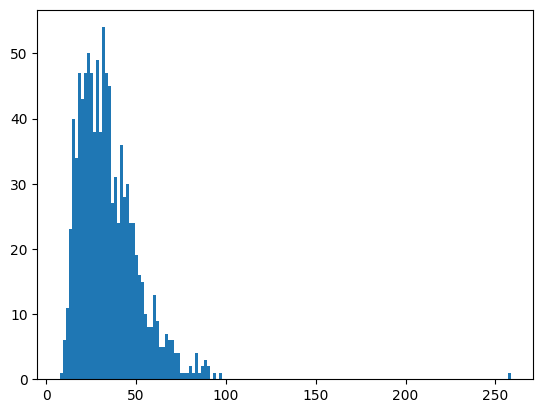

In [13]:
import matplotlib.pyplot as plt

exp_to_diff = {val:key for val, key in result}
plt.hist(diffs, bins=150)
plt.show()

In [14]:
K = len(result) // 3

sorted_res = [exp for exp, v in sorted(result, key=lambda x: x[1])]
easy = sorted_res[0: K]
medium = sorted_res[K: 2*K]
hard = sorted_res[2*K: 3*K]

In [15]:
N = 8

np.random.seed(1729)
images = np.random.choice(len(easy), size=10*N, replace=False)
for n_batch in tqdm(range(len(images) // N)):
    try:
        batch = images[N * n_batch: N * (n_batch + 1)]
        batch_exp = [easy[i] for i in batch]
        img = get_transform_image_exp(batch_exp, exp_to_path)
        img = column_named(img, [str(round(exp_to_diff[easy[i]], 2)) for i in batch])
        img.save(f'/home/mdnikolaev/ImageEditing/exps/methods-compare-1809/easy-image-{n_batch}.png')
    except:
        pass

  0%|          | 0/10 [00:00<?, ?it/s]

In [16]:
N = 8

np.random.seed(1729)
images = np.random.choice(len(medium), size=10*N, replace=False)
for n_batch in tqdm(range(len(images) // N)):
    try:
        batch = images[N * n_batch: N * (n_batch + 1)]
        batch_exp = [medium[i] for i in batch]
        img = get_transform_image_exp(batch_exp, exp_to_path)
        img = column_named(img, [str(round(exp_to_diff[medium[i]], 2)) for i in batch])
        img.save(f'/home/mdnikolaev/ImageEditing/exps/methods-compare-1809/medium-image-{n_batch}.png')
    except:
        pass

  0%|          | 0/10 [00:00<?, ?it/s]

In [17]:
N = 8

np.random.seed(1729)
images = np.random.choice(len(hard), size=10*N, replace=False)
for n_batch in tqdm(range(len(images) // N)):
    try:
        batch = images[N * n_batch: N * (n_batch + 1)]
        batch_exp = [hard[i] for i in batch]
        img = get_transform_image_exp(batch_exp, exp_to_path)
        img = column_named(img, [str(round(exp_to_diff[hard[i]], 2)) for i in batch])
        img.save(f'/home/mdnikolaev/ImageEditing/exps/methods-compare-1809/hard-image-{n_batch}.png')
    except:
        pass

  0%|          | 0/10 [00:00<?, ?it/s]